**Camera Calibration with Charuco Board** (opencv-python 4.5.5.62)

Data preparation

In [13]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [2]:
# Load the video
video_path = '../data/calib_images/zed_left_0326.mp4'
cap = cv2.VideoCapture(video_path)

# Create a directory to store the calibration images
calibration_dir = '../data/calib_images/calibration_images'
os.makedirs(calibration_dir, exist_ok=True)

frame_count = 0
downsample_factor = 5  # Adjust this value to control the downsampling rate

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % downsample_factor == 0:
        # Check if the frame is blurry
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()

        if blur_score > 50:  # Adjust the threshold as needed
            # Save the non-blurry frame as a calibration image
            calibration_image_path = os.path.join(calibration_dir, f'frame_{frame_count}.jpg')
            cv2.imwrite(calibration_image_path, frame)
        
    frame_count += 1

cap.release()

Calibration

In [12]:

selected_image_path = '../data/calib_images/selected_images'
os.makedirs(selected_image_path, exist_ok=True)
# ChArUco board parameters
CHARUCOBOARD_ROWCOUNT = 11
CHARUCOBOARD_COLCOUNT = 9
ARUCO_DICT = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_1000)
SQUARE_LENGTH = 0.047  # Checker size in meters
MARKER_LENGTH = 0.035  # Marker size in meters

# Create the ChArUco board
board = cv2.aruco.CharucoBoard_create(
    squaresX=CHARUCOBOARD_COLCOUNT,
    squaresY=CHARUCOBOARD_ROWCOUNT,
    squareLength=SQUARE_LENGTH,
    markerLength=MARKER_LENGTH,
    dictionary=ARUCO_DICT
)

calibration_images = [os.path.join(calibration_dir, f) for f in os.listdir(calibration_dir) if f.endswith('.jpg')]
# Choose a random sample of images
num_images_to_choose = 30  # Specify the number of images to choose
calibration_images = random.sample(calibration_images, num_images_to_choose)

# # Display the images
# for image_path in calibration_images:
#     image = cv2.imread(image_path)
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()
    
all_corners = []
all_ids = []

for image_path in calibration_images:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    
    # Detect ArUco markers
    corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT)

    if len(corners) > 0:
        # Refine detected markers
        corners, ids, _, _ = cv2.aruco.refineDetectedMarkers(
            image=gray,
            board=board,
            detectedCorners=corners,
            detectedIds=ids,
            rejectedCorners=None,
            cameraMatrix=None,
            distCoeffs=None
        )

        if len(corners) > 0:
            # Interpolate charuco corners
            ret, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(
                markerCorners=corners,
                markerIds=ids,
                image=gray,
                board=board
            )

            if ret > 3:
                all_corners.append(charuco_corners)
                all_ids.append(charuco_ids)

# Calibrate the camera
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.aruco.calibrateCameraCharuco(
    charucoCorners=all_corners,
    charucoIds=all_ids,
    board=board,
    imageSize=gray.shape[::-1],
    cameraMatrix=None,
    distCoeffs=None
)

print("Camera calibration successful:", ret)
print("Camera Matrix:\n", camera_matrix)
print("Distortion Coefficients:\n", dist_coeffs)

# Save the calibration results
# np.savez('calibration.npz', camera_matrix=camera_matrix, dist_coeffs=dist_coeffs)
# Estimate pose and reproject markers for each calibration image

Camera calibration successful: 0.9847774633239249
Camera Matrix:
 [[1.44496060e+03 0.00000000e+00 9.60852464e+02]
 [0.00000000e+00 1.45225080e+03 4.95380959e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
 [[ 0.02427558 -0.10294355 -0.00357189  0.00457016  0.14127053]]


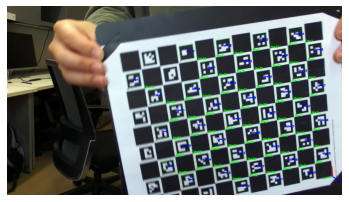

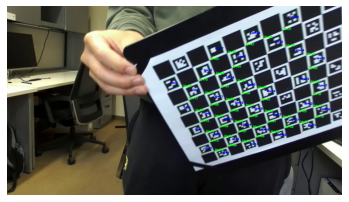

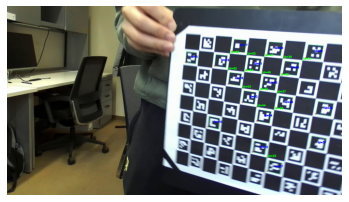

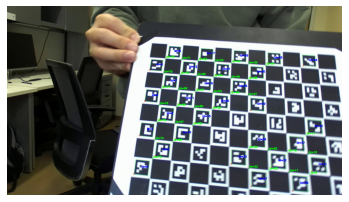

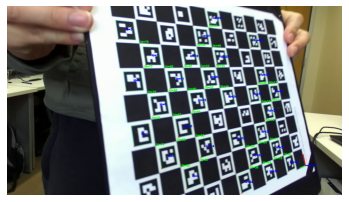

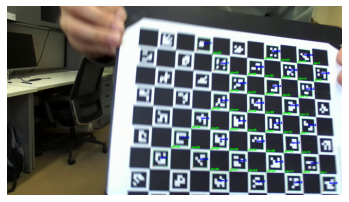

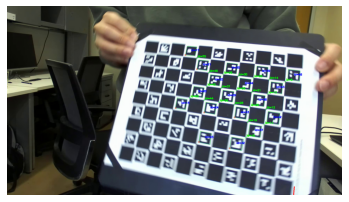

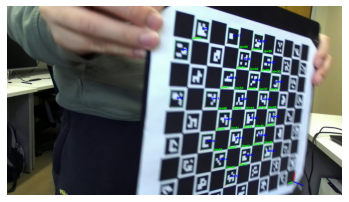

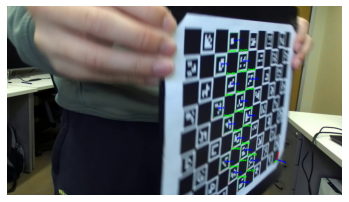

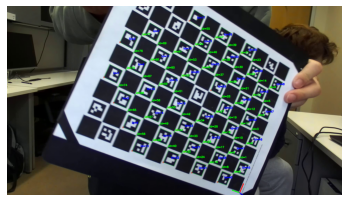

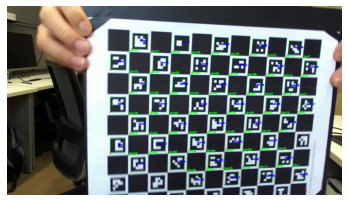

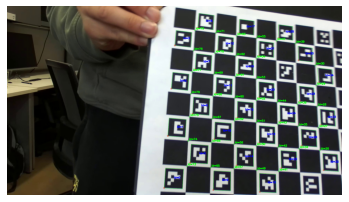

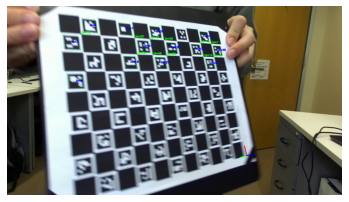

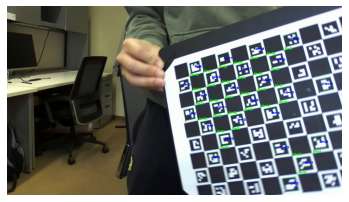

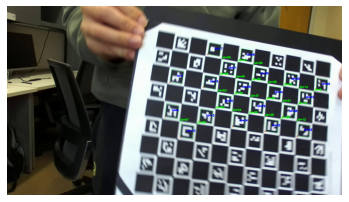

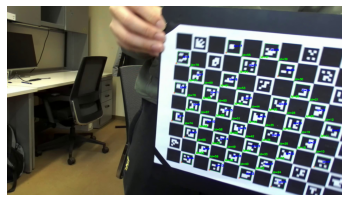

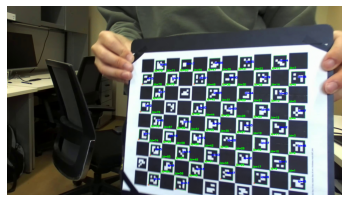

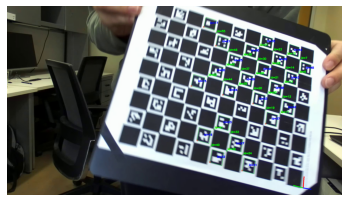

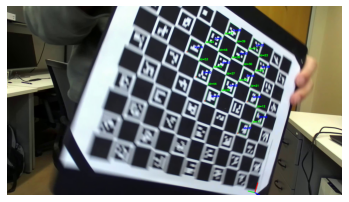

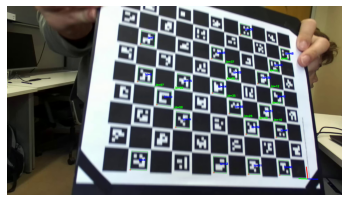

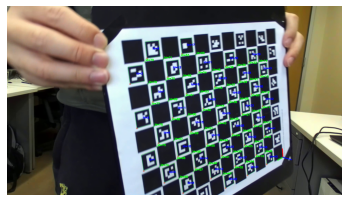

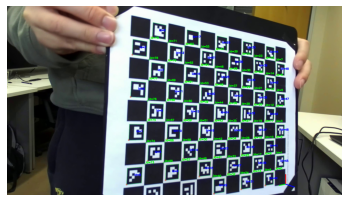

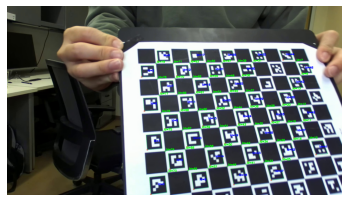

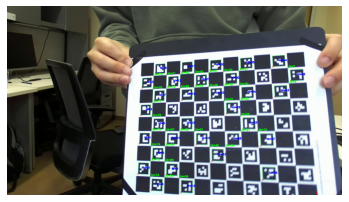

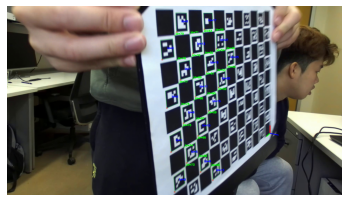

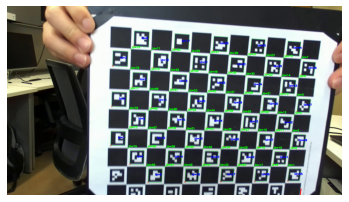

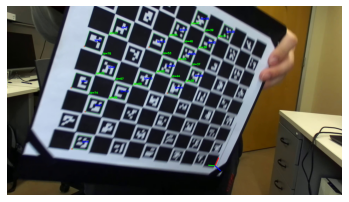

In [22]:
corners_image_path = '../data/calib_images/corners_images'
for image_path in calibration_images:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect ArUco markers
    corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT)

    if len(corners) > 0:
        # Refine detected markers
        corners, ids, _, _ = cv2.aruco.refineDetectedMarkers(
            image=gray,
            board=board,
            detectedCorners=corners,
            detectedIds=ids,
            rejectedCorners=None,
            cameraMatrix=camera_matrix,
            distCoeffs=dist_coeffs
        )

        if len(corners) > 0:
            # Interpolate charuco corners
            ret, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(
                markerCorners=corners,
                markerIds=ids,
                image=gray,
                board=board
            )

            if ret > 3:
                # Draw detected markers
                image_markers = cv2.aruco.drawDetectedMarkers(image.copy(), corners, ids)

                # Estimate pose and reproject markers
                ret, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(
                    charucoCorners=charuco_corners,
                    charucoIds=charuco_ids,
                    board=board,
                    cameraMatrix=camera_matrix,
                    distCoeffs=dist_coeffs,
                    rvec=None,
                    tvec=None
                )

                if ret:
                    # Draw reprojected markers
                    image_reproj = cv2.aruco.drawDetectedCornersCharuco(
                        image=image_markers,
                        charucoCorners=charuco_corners,
                        charucoIds=charuco_ids,
                        cornerColor=(0, 255, 0)  # Green color for reprojected markers
                    )
                    # Draw the axis for the origin
                    cv2.aruco.drawAxis(
                        image=image_reproj,
                        cameraMatrix=camera_matrix,
                        distCoeffs=dist_coeffs,
                        rvec=rvec,
                        tvec=tvec,
                        length=0.03
                    )
                    # Display the image with detected and reprojected markers
                    plt.imshow(cv2.cvtColor(image_reproj, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.show()
                    cv2.imwrite(os.path.join(corners_image_path, f'{os.path.basename(image_path)}'), image_reproj)
                    # cv2.imshow("Reprojection", image_reproj)
                    # cv2.waitKey(0)